# **library installation**

In [9]:
#  install tensorflow with conda
#  conda install -c conda-forge tensorflow

#import essential libraries
import tensorflow as tf
import keras as keras

print(" TensorFlow version:", tf.__version__)
print(" Keras version:", keras.__version__)

#import basic libraries
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import gdown
import zipfile


from torchvision import models, transforms
from PIL import Image



# tensorflow imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

 TensorFlow version: 2.17.0
 Keras version: 3.4.1


#**Import database**

In [ ]:

#root_dir = Path.cwd()
root_dir = Path('/content/drive/MyDrive/Lambton/ai_lab')

# Define the images directory
images_dir = root_dir / 'data' / 'images'

# Define the output directories
train_dir = root_dir / 'data' / 'training'
test_dir = root_dir / 'data' / 'test'

# Define the classes based on filename prefixes
classes = ['level0', 'level1', 'level2', 'level3']

prefix_mapping = {
    'level0': 'levle0_',
    'level1': 'levle1_',
    'level2': 'levle2_',
    'level3': 'levle3_'
}

#print(root_dir) # it is necessary print?

In [ ]:
print(root_dir) # it is necessary print?


/content/drive/MyDrive/Lambton/ai_lab


##Fuction import database

In [ ]:
# ensures that the training and test directories, along with their class subdirectories, exist.

for split_dir in [train_dir, test_dir]:
    for cls in classes:
        class_path = split_dir / cls
        class_path.mkdir(parents=True, exist_ok=True)

# Function to Split and Copy Images
def split_and_copy_images():
    for cls in classes:
        # Get the corresponding prefix for the current class
        cls_prefix = prefix_mapping.get(cls)

        if not cls_prefix:
            printimport torch

#**data processing**

In [ ]:
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)(f"No prefix defined for class '{cls}'. Skipping.")
            continue

        # Retrieve all images belonging to the current class
        cls_images = [img for img in images_dir.iterdir() if img.is_file() and img.name.startswith(cls_prefix)]

        # Split the images into training and testing sets (75% train, 25% test)
        train_images, test_images = train_test_split(
            cls_images,
            test_size=0.25,
            random_state=42,  # Ensures reproducibility
            shuffle=True)

        # Copy training images
        for img_path in train_images:
            destination = train_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        # Copy testing images
        for img_path in test_images:
            destination = test_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        print(f"Class '{cls}': {len(train_images)} training and {len(test_images)} testing images copied.")

# Execute the function
split_and_copy_images()
print("All images have been successfully split into training and test sets.")

In [ ]:
# Get the class names for our multi-class dataset
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['level0' 'level1' 'level2' 'level3']


## image display function

In [ ]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = Path(target_dir) / target_class
  print(target_folder)
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0]

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder / random_image)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

##image display

/content/drive/MyDrive/Lambton/ai_lab/data/training/level0
Image shape: (3456, 3112, 3)


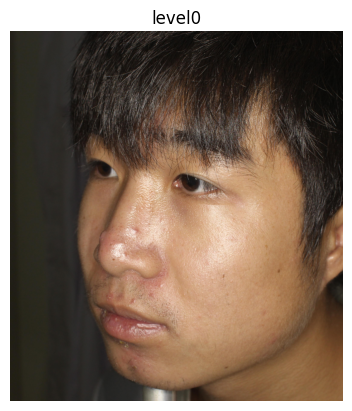

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(classes)) # get a random class name

# **Transfer learning test**

In [ ]:
# Create datasets using image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 label_mode='categorical', # for multi-class classification
                                                                 shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                label_mode='categorical')

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to test data
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance (overlap data preprocessing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


NameError: name 'tf' is not defined

# **MODELS**

### MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Transfer learning: use pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 947ms/step - accuracy: 0.6531 - loss: 0.7668
Test accuracy: 0.63


### ResNet50

In [ ]:
from keras.applications import ResNet50

# Use ResNet50 instead of MobileNetV2
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the new model
model_RN = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile the model
model_RN.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model_RN.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.4088 - loss: 1.3549 - val_accuracy: 0.3406 - val_loss: 1.2447 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4133 - loss: 1.2773 - val_accuracy: 0.4360 - val_loss: 1.2305 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4146 - loss: 1.2285 - val_accuracy: 0.4360 - val_loss: 1.2209 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4302 - loss: 1.2284 - val_accuracy: 0.4360 - val_loss: 1.2138 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4211 - loss: 1.2445 - val_accuracy: 0.4360 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4037 - loss: 1.2346 - val_accuracy: 0.4360 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 7/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4540 - loss: 1.2134
Epoch 7: Reduc

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_RN.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4614 - loss: 1.1901
Test accuracy: 0.44


In [ ]:
from keras.applications import EfficientNetB0

# Transfer learning: use pre-trained MobileNetV2 model
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model_EN = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model_EN.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Train the model
history = model_EN.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.3775 - loss: 1.2784 - val_accuracy: 0.4360 - val_loss: 1.2192 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4223 - loss: 1.2274 - val_accuracy: 0.4360 - val_loss: 1.2187 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4390 - loss: 1.2108 - val_accuracy: 0.4360 - val_loss: 1.2166 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3684 - loss: 1.2453 - val_accuracy: 0.4360 - val_loss: 1.2173 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.4439 - loss: 1.2213 - val_accuracy: 0.4360 - val_loss: 1.2166 - learning_rate: 0.0010
Epoch 6/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4038 - loss: 1.2393
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4043 - loss: 1.2388 - val_accuracy: 0

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_RN.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

NameError: name 'model_RN' is not defined

Here is a table summarizing and comparing the training results for each base model:

| Model            | Epochs Before Early Stop | Train Accuracy | Train Loss | Validation Accuracy | Validation Loss | Learning Rate |
|------------------|--------------------------|----------------|------------|---------------------|-----------------|---------------|
| ResNet50         | 9                        | 0.4370         | 1.2194     | 0.4360              | 1.2154          | 5.0e-04       |
| EfficientNetB0   | 8                        | 0.4296         | 1.2149     | 0.4360              | 1.2169          | 5.0e-04       |



In [ ]:
%pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNetV2
from keras.optimizers import Adam
import keras_tuner as kt

# Define a function to build the model
def build_model(hp):
    # Transfer learning: use pre-trained MobileNetV2 model
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the KerasTuner for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='acne_classification'
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Determine the size of the dataset
dataset_size = train_data.cardinality().numpy()

# Define the split ratio
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

# Split the dataset
train_dataset = train_data.take(train_size)
val_dataset = train_data.skip(train_size)

# Perform the search with KerasTuner
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from hyperparam_tuning/acne_classification/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.2               |0.2               |dropout1
64                |64                |units
0.3               |0.3               |dropout2
0.0099472         |0.0099472         |learning_rate

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4332 - loss: 2.4691 - val_accuracy: 0.5052 - val_loss: 1.0032 - learning_rate: 0.0099
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.4780 - loss: 1.0858 - val_accuracy: 0.5361 - val_loss: 0.9834 - learning_rate: 0.0099
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4506 - loss: 1.0510 - val_accuracy: 0.5258 - val_loss: 0.9312 - learning_rate: 0.0099
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5229 - loss: 1.0298

KeyboardInterrupt: 

## Normal training

In [ ]:
# Create baseline model
model_baseline = Sequential([
    Input(shape=(224, 224, 3)),  # Define input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout before output layer
    Dense(4, activation='softmax')  # 4 neurons for the 4 classes
])

# Compile the model with a learning rate scheduler
model_baseline.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 296,420 (1.13 MB)

 Trainable params: 295,972 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 verbose=1,
                                 min_lr=1e-6)

# Optional: Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [ ]:
# Fit the model with callbacks
history = model_baseline.fit(train_data,
                         epochs=10,
                         validation_data=test_data,
                         callbacks=[lr_scheduler, checkpoint])

Epoch 1/10
33/35 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.3460 - loss: 1.4077

KeyboardInterrupt: 

In [ ]:
# Evaluate on the test data
model_baseline.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4664 - loss: 1.2688


[1.2846068143844604, 0.4332424998283386]

## Plot results

### Normal training

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    # Extract loss and accuracy from the history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Get the number of epochs

    # Plot loss
    plt.figure(figsize=(12, 5))  # Set figure size for better readability
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots


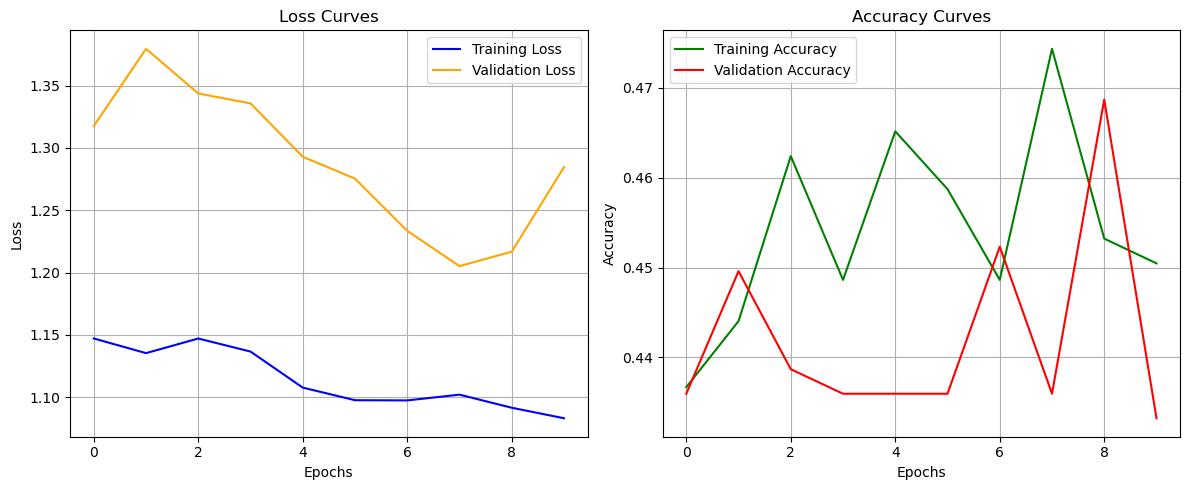

In [ ]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

### Transfer learning

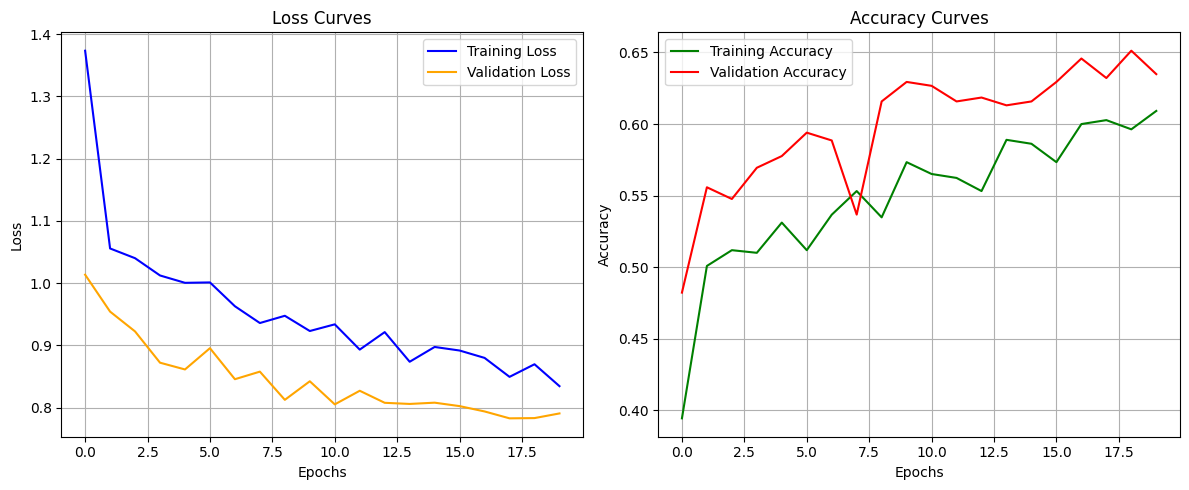

In [ ]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

## Save model

In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')  # Save the model as a .h5 file

In [ ]:
# Load the saved .keras model
from keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')



In [ ]:
# Evaluate the loaded model on test data
test_loss, test_acc = loaded_model.evaluate(test_data)
print(f"Loaded .keras model test accuracy: {test_acc:.2f}")

In [ ]:
loaded_model.summary()

## Transformers

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Define the feature extractor and model

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224", do_rescale=False)# Avoid rescaling as images are already in [0, 1]
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(class_names),
    attn_implementation="eager",
    output_attentions=True,  # Enable attention outputs
    ignore_mismatched_sizes=True # Add this line to ignore size mismatches

)
# Freeze layers if fine-tuning
for param in model.vit.parameters():
    param.requires_grad = False

# Define updated transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Keeps values in the [0, 1] range
])



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch

# Set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Preprocess images once and create a custom Dataset
class PreprocessedDataset(Dataset):
    def __init__(self, dataset, feature_extractor):
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.pixel_values = []
        self.labels = []

        # Pre-process each image
        for img, label in dataset:
            inputs = feature_extractor(img, return_tensors="pt")
            self.pixel_values.append(inputs.pixel_values.squeeze())  # Remove batch dim
            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]

# Initialize dataset and dataloader
train_dataset = PreprocessedDataset(train_dataset, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
# Define model, optimizer, and loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):  # Train for 20 epochs (or more if desired)
    model.train()
    for pixel_values, labels in train_loader:
        pixel_values, labels = pixel_values.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.8300151228904724
Epoch 2, Loss: 0.5436853170394897
Epoch 3, Loss: 0.8309531211853027
Epoch 4, Loss: 0.446732759475708
Epoch 5, Loss: 0.48302918672561646
Epoch 6, Loss: 0.6113755106925964
Epoch 7, Loss: 0.6121990084648132
Epoch 8, Loss: 0.9156056642532349
Epoch 9, Loss: 1.47538161277771
Epoch 10, Loss: 0.984542191028595
Epoch 11, Loss: 0.849412202835083
Epoch 12, Loss: 0.6091943383216858
Epoch 13, Loss: 0.6283968091011047
Epoch 14, Loss: 0.52024245262146
Epoch 15, Loss: 0.2352135181427002
Epoch 16, Loss: 0.45923447608947754
Epoch 17, Loss: 1.5366430282592773
Epoch 18, Loss: 0.6019067168235779
Epoch 19, Loss: 0.6763912439346313
Epoch 20, Loss: 0.6167719960212708


### Save model

In [ ]:
# Save the entire model (including architecture and weights)
torch.save(model, 'my_vit_model.pth')

# Alternatively, save only the model's state_dict (recommended for flexibility)
torch.save(model.state_dict(), 'my_vit_model_state_dict.pth')

### Load model

In [ ]:
# Load the entire model
loaded_model = torch.load('my_vit_model.pth')

# Or, load the state_dict into a new model instance
#new_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224') # Assuming this is your model architecture
#new_model.load_state_dict(torch.load('my_vit_model_state_dict.pth'))

In [ ]:
# Helper function to visualize attention on image
def show_attention_on_image(image, attention_map):
    # Resize attention map to image dimensions
    attention_map_resized = cv2.resize(attention_map, (image.size[0], image.size[1]))

    # Normalize attention map to be between 0 and 1
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / \
                            (attention_map_resized.max() - attention_map_resized.min())

    # Overlay attention on the image
    overlay = np.array(image) * 0.5 + np.array(image) * attention_map_resized[..., None] * 0.5
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

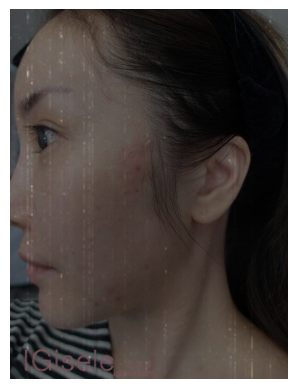

In [ ]:
image_path = "/content/drive/MyDrive/Lambton/ai_lab/data/training/level0/levle0_0.jpg"
image = Image.open(image_path)
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

# Run model and get attention weights
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Select a specific layer and head for visualization
layer = -1  # Last layer
head = 0    # First attention head
attention_map = outputs.attentions[layer][0, head].cpu().numpy()

# Show attention map overlaid on the original image
show_attention_on_image(image, attention_map)

### Evaluation

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Make sure to set the model to evaluation mode
model.eval()

# Prepare to store predictions and true labels
all_preds = []
all_labels = []


In [ ]:
# Evaluation loop
with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        # Move images and labels to the appropriate device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get logits, ensuring pixel_values are on the correct device
        outputs = model(pixel_values=feature_extractor(images, return_tensors="pt").pixel_values.to(device))

        # Get predicted class indices
        preds = torch.argmax(outputs.logits, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Generate a classification report for precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


Accuracy: 0.5450
              precision    recall  f1-score   support

      level0       0.78      0.25      0.38       125
      level1       0.52      0.68      0.59       160
      level2       0.39      0.62      0.48        47
      level3       0.70      0.89      0.78        35

    accuracy                           0.54       367
   macro avg       0.60      0.61      0.56       367
weighted avg       0.61      0.54      0.52       367



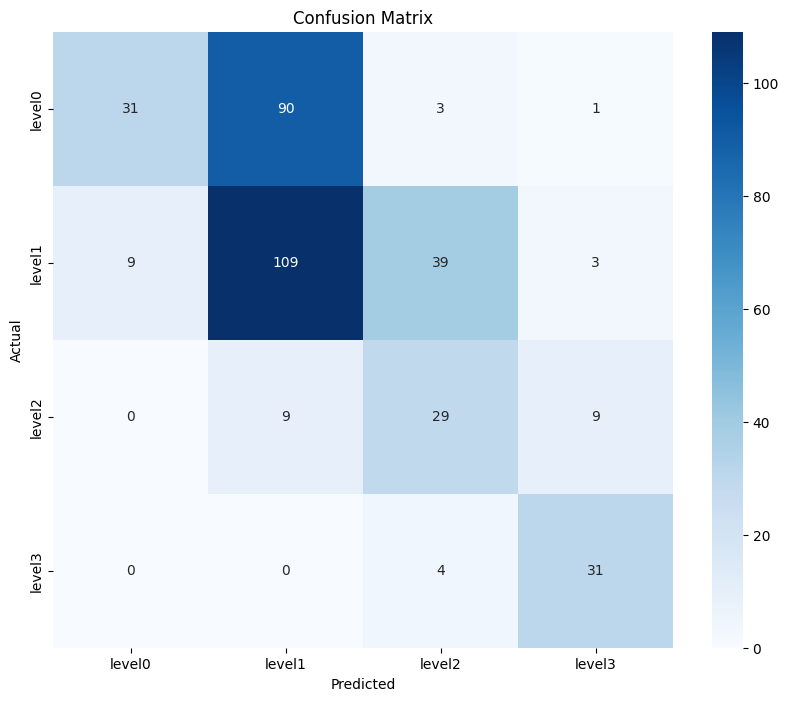

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## ResNEt50 GradCam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dir = train_dir  # Replace with your train dataset path
val_dir = test_dir     # Replace with your validation dataset path

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load pre-trained ResNet-50 model and modify for our number of classes
num_classes = len(train_dataset.classes)  # Adjust based on your dataset
model = models.resnet50(pretrained=True)

# Ensure model's final fully connected layer has the correct output size
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Verify requires_grad is True for all parameters
for param in model.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()  # Ensure gradient computation
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    print(f"Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# Main training loop
num_epochs = 10  # Adjust as needed
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save the model if it has the best accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("Model saved!")

    print(f"Epoch {epoch+1} completed. Best Val Acc: {best_val_acc:.4f}\n")

print("Training finished.")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10
Train Loss: 1.0882, Train Acc: 0.5138
Val Loss: 1.4396, Val Acc: 0.4605
Model saved!
Epoch 1 completed. Best Val Acc: 0.4605

Epoch 2/10
Train Loss: 0.8579, Train Acc: 0.5982
Val Loss: 1.0453, Val Acc: 0.6049
Model saved!
Epoch 2 completed. Best Val Acc: 0.6049

Epoch 3/10
Train Loss: 0.8511, Train Acc: 0.6092
Val Loss: 3.0154, Val Acc: 0.4523
Epoch 3 completed. Best Val Acc: 0.6049

Epoch 4/10
Train Loss: 0.8049, Train Acc: 0.6431
Val Loss: 1.1415, Val Acc: 0.5450
Epoch 4 completed. Best Val Acc: 0.6049

Epoch 5/10
Train Loss: 0.7196, Train Acc: 0.6798
Val Loss: 0.9559, Val Acc: 0.5450
Epoch 5 completed. Best Val Acc: 0.6049

Epoch 6/10
Train Loss: 0.6832, Train Acc: 0.7055
Val Loss: 3.0792, Val Acc: 0.1553
Epoch 6 completed. Best Val Acc: 0.6049

Epoch 7/10
Train Loss: 0.9248, Train Acc: 0.6257
Val Loss: 0.9378, Val Acc: 0.6104
Model saved!
Epoch 7 completed. Best Val Acc: 0.6104

Epoch 8/10
Train Loss: 0.7203, Train Acc: 0.7028
Val Loss: 2.3024, Val Acc: 0.3597
Epoch 8 co

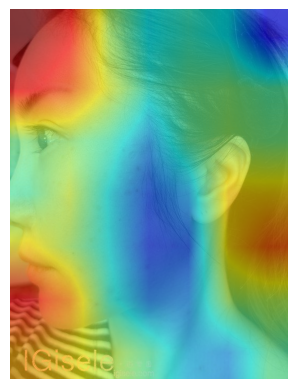

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define transformations for the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess the image
def get_img_array(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Variables to store gradients and activations
gradients = None
activations = None

# Define a hook to capture the gradients of the target layer
def save_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Define a hook to capture the activations of the target layer
def save_activations(module, input, output):
    global activations
    activations = output

# Choose the target layer (last conv layer in ResNet-50)
target_layer = model.layer4[-1]
target_layer.register_forward_hook(save_activations)
target_layer.register_backward_hook(save_gradients)

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_tensor, model, class_idx=None):
    img_tensor = img_tensor.to(device)

    # Forward pass
    output = model(img_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    # Backward pass: compute gradients with respect to the chosen class
    model.zero_grad()
    target = output[0, class_idx]
    target.backward()

    # Get activations and gradients, move to CPU for numpy operations
    global activations, gradients
    activations = activations.cpu().detach().numpy()
    gradients = gradients.cpu().detach().numpy()

    # Compute the weights for each channel
    pooled_gradients = np.mean(gradients, axis=(2, 3))[0]

    # Weight the channels by gradients
    for i in range(activations.shape[1]):
        activations[0, i, :, :] *= pooled_gradients[i]

    # Generate heatmap by taking mean across channels
    heatmap = np.mean(activations[0], axis=0)
    heatmap = np.maximum(heatmap, 0)  # ReLU to keep only positive values
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap

# Function to overlay the heatmap on the image
def show_gradcam_on_image(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Usage example
image_path = "/content/drive/MyDrive/Lambton/ai_lab/data/training/level0/levle0_0.jpg"
img_tensor = get_img_array(image_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_tensor, model)

# Display the Grad-CAM overlay
show_gradcam_on_image(image_path, heatmap)


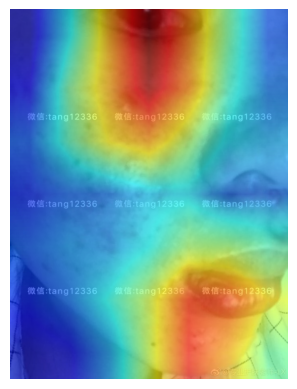

In [ ]:
# Usage example
image_path = "/content/drive/MyDrive/Lambton/ai_lab/data/training/level2/levle2_3.jpg"
img_tensor = get_img_array(image_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_tensor, model)

# Display the Grad-CAM overlay
show_gradcam_on_image(image_path, heatmap)

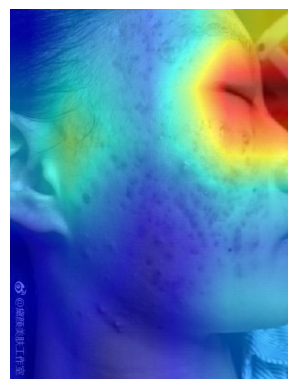

In [ ]:
# Usage example
image_path = "/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_3.jpg"
img_tensor = get_img_array(image_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_tensor, model)

# Display the Grad-CAM overlay
show_gradcam_on_image(image_path, heatmap)